### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

### Load Dataset

In [2]:
df_raw = pd.read_csv('../data/gold_price_data.csv')

In [3]:
print("=== BASIC SHAPE & COLUMNS ===")
print("Shape:", df_raw.shape)
print("Columns:", df_raw.columns.tolist())

=== BASIC SHAPE & COLUMNS ===
Shape: (5215, 7)
Columns: ['date', 'open', 'high', 'low', 'close', 'adj_close', 'volume']


###  Data Dictionary

| Column         | Description                                                                        |
| -------------- | ---------------------------------------------------------------------------------- |
| **date**       | วันที่ของข้อมูล                                                                    |
| **open**       | ราคาทองคำตอนเปิดตลาด                                                               |
| **high**       | ราคาสูงสุดของวันนั้น                                                               |
| **low**        | ราคาต่ำสุดของวันนั้น                                                               |
| **close**      | ราคาปิดตลาด (ปรับสำหรับ stock split แล้ว)                                          |
| **adj\_close** | ราคาปิดตลาดที่ปรับด้วย stock splits และ dividend distributions ตามมาตรฐาน **CRSP** |
| **volume**     | ปริมาณการซื้อขาย (จำนวนหุ้นที่ถูกซื้อขายในวันนั้น)                                 |

### Summary

In [4]:
print(df_raw.dtypes)

date          object
open         float64
high         float64
low          float64
close        float64
adj_close    float64
volume         int64
dtype: object


In [5]:
print("\n=== NULL COUNTS (per column) ===")
print(df_raw.isna().sum())


=== NULL COUNTS (per column) ===
date         0
open         0
high         0
low          0
close        0
adj_close    0
volume       0
dtype: int64


In [6]:
summary = {
    "rows": len(df_raw),
    "date_min": pd.to_datetime(df_raw['date']).min().date().isoformat(),
    "date_max": pd.to_datetime(df_raw['date']).max().date().isoformat(),
    "close_min": float(df_raw['close'].min()),
    "close_max": float(df_raw['close'].max()),
    "adj_close_min": float(df_raw['adj_close'].min()),
    "adj_close_max": float(df_raw['adj_close'].max())
}

summary


{'rows': 5215,
 'date_min': '2004-11-18',
 'date_max': '2025-08-12',
 'close_min': 41.02000045776367,
 'close_max': 315.0400085449219,
 'adj_close_min': 41.02999877929688,
 'adj_close_max': 317.489990234375}

### Clean & Index


In [7]:

# ทำสำเนา dataset
df = df_raw.copy()

# 1) แปลงคอลัมน์ date เป็น datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# 2) ลบแถวที่ date ไม่สามารถแปลงได้
df = df.dropna(subset=['date'])

# 3) เรียงข้อมูลตาม date
df = df.sort_values('date').reset_index(drop=True)

# 4) ตั้ง date เป็น index
df = df.set_index('date')

# 5) กันวันที่ซ้ำ — เก็บแถวแรกไว้
df = df[~df.index.duplicated(keep='first')]

# 6) Summary เบื้องต้น
summary = {
    "rows": len(df),
    "date_min": df.index.min().date().isoformat(),
    "date_max": df.index.max().date().isoformat(),
    "close_min": float(df['close'].min()),
    "close_max": float(df['close'].max()),
    "adj_close_min": float(df['adj_close'].min()),
    "adj_close_max": float(df['adj_close'].max())
}
summary


{'rows': 5215,
 'date_min': '2004-11-18',
 'date_max': '2025-08-12',
 'close_min': 41.02000045776367,
 'close_max': 315.0400085449219,
 'adj_close_min': 41.02999877929688,
 'adj_close_max': 317.489990234375}

### Visualization: Moving Average

#### Technical Indicators

Technical Indicators เป็นเครื่องมือวิเคราะห์ทางเทคนิคที่นิยมใช้ในตลาดการเงิน
ช่วยเสริมการมองเห็นแนวโน้ม (trend), ความแรง (momentum) และความผันผวน (volatility)

---

####  Moving Average (MA)

Moving Average (MA) คือ การคำนวณค่าเฉลี่ยของราคาย้อนหลัง *N วัน* แล้วเลื่อน (rolling) ไปเรื่อย ๆ
เพื่อช่วย **ลดความผันผวนระยะสั้น (noise)** และแสดง **แนวโน้ม (trend)** ของราคาได้ชัดเจนขึ้น

---

ประเภทของ MA ที่ใช้บ่อย

* **MA50** → ค่าเฉลี่ยย้อนหลัง 50 วัน

  * ใช้ดูแนวโน้ม ระยะสั้นถึงกลาง
* **MA200** → ค่าเฉลี่ยย้อนหลัง 200 วัน

  * ใช้ดูแนวโน้ม ระยะยาว

---

การตีความ

* ถ้า MA50 > MA200 → แนวโน้มขาขึ้น (Bullish Trend)
* ถ้า MA50 < MA200 → แนวโน้มขาลง (Bearish Trend)
* จุดที่เส้น MA50 ตัดขึ้นเหนือ MA200 → เรียกว่า Golden Cross (สัญญาณเชิงบวก)
* จุดที่เส้น MA50 ตัดลงใต้ MA200 → เรียกว่า Death Cross (สัญญาณเชิงลบ)

---



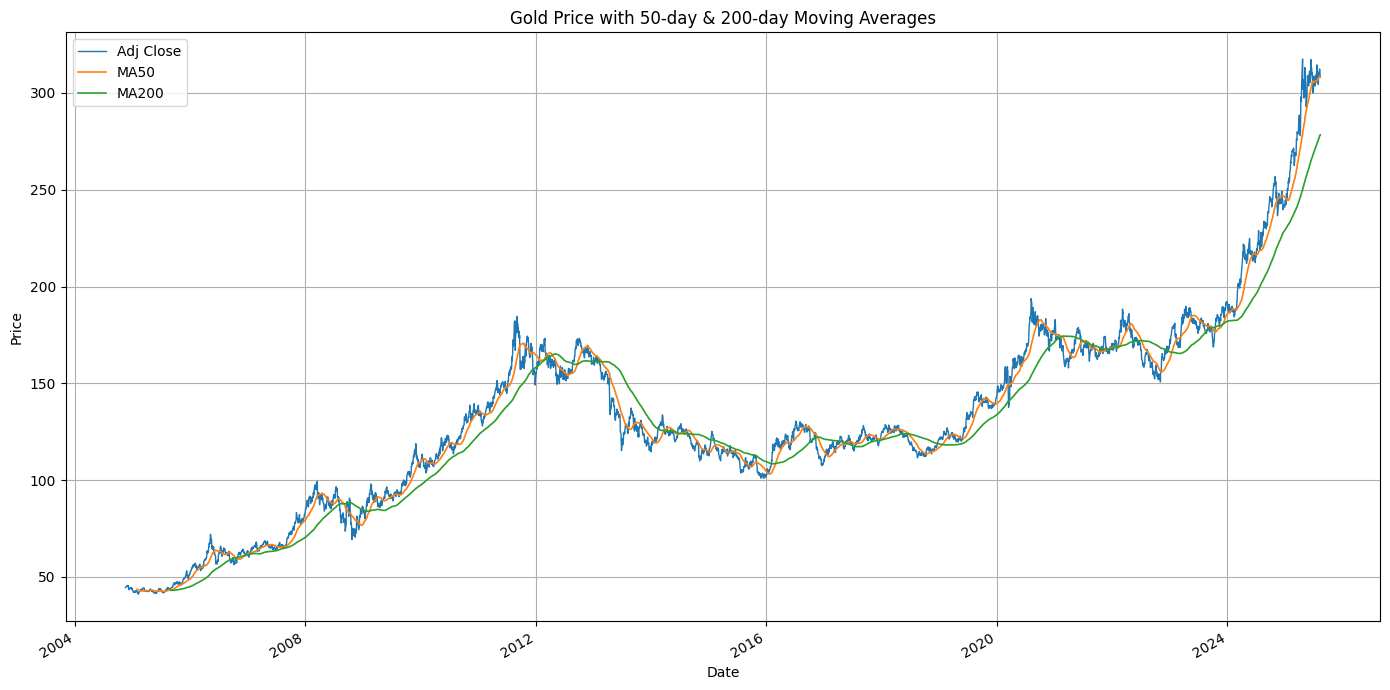

In [8]:
plt.figure(figsize=(14, 7))

# Plot ราคาปิดที่ปรับแล้ว
df['adj_close'].plot(label='Adj Close', linewidth=1)

# Plot MA50 และ MA200
df['adj_close'].rolling(50).mean().plot(label='MA50', linewidth=1.2)
df['adj_close'].rolling(200).mean().plot(label='MA200', linewidth=1.2)

plt.title('Gold Price with 50-day & 200-day Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


---

RSI (Relative Strength Index)

เป็นตัวชี้วัด โมเมนตัม (momentum) ของราคา
คำนวณจากการเปรียบเทียบ “การขึ้น” กับ “การลง” ของราคาย้อนหลัง (เช่น 14 วัน)
ค่าอยู่ในช่วง 0 – 100
- RSI > 70 → ตลาดอยู่ในสภาวะ Overbought (ราคาขึ้นแรงเกินไป อาจมีโอกาสปรับฐานลง)
- RSI < 30 → ตลาดอยู่ในสภาวะ Oversold (ราคาลงแรงเกินไป อาจมีโอกาสเด้งกลับขึ้น)



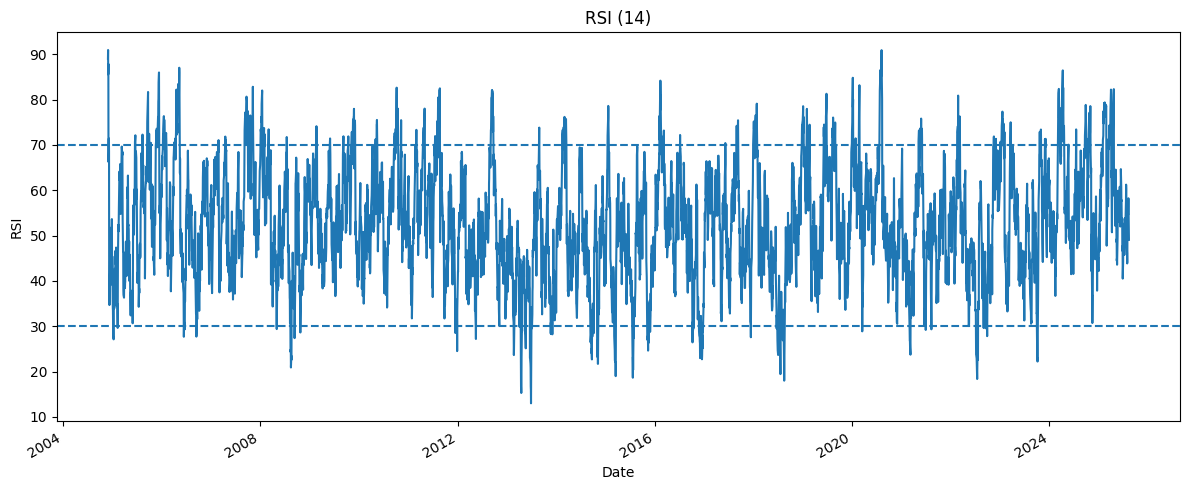

In [9]:
def compute_rsi(series: pd.Series, period: int = 14) -> pd.Series:
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)

    # Wilder’s smoothing ด้วย ewm(alpha=1/period)
    avg_gain = gain.ewm(alpha=1/period, adjust=False).mean()
    avg_loss = loss.ewm(alpha=1/period, adjust=False).mean()

    rs = avg_gain / avg_loss.replace(0, np.nan)
    rsi = 100 - (100 / (1 + rs))
    return rsi

rsi_14 = compute_rsi(df['adj_close'], period=14)

plt.figure(figsize=(12, 5))
rsi_14.plot()
plt.title('RSI (14)')
plt.xlabel('Date'); plt.ylabel('RSI')
plt.axhline(70, linestyle='--')
plt.axhline(30, linestyle='--')
plt.tight_layout(); plt.show()
